# Importing

## Importing modules

In [360]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import time
import random
import math
from multiprocessing import Process, Queue

import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.models import load_model
from keras.optimizers import SGD, adam, adagrad, rmsprop

## Importing own code

In [361]:
from generateSpace import *
from plotLattice import *
from getTriangleLengths import *
from potentialEnergyPerTrio import *
from potentialEnergy import *
from potentialEnergyPerParticle import *
from numberOfCalculations import *
from makeRandomDatabase import *
from prepareDatabaseForMachineLearning import*

## Writing own code

### Analysis code

In [362]:
def plotHistory(fitDetails):
    """
    hjhgj
    """
    history = {'loss': fitDetails.history['loss'], 'val_loss': fitDetails.history['val_loss']}
    
    maximumValue = max(max(history['loss']), max(history['val_loss']))
    minimumValue = min(min(history['loss']), min(history['val_loss'])) / 10#math.pow(math.floor(math.log(min(min(history['loss']), min(history['val_loss'])), 10)) - 1, 10)
    numberOfEpochs = len(history['loss'])
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
    ax1.plot([i for i in range(1, numberOfEpochs + 1)], history['loss'], label='Training loss')
    ax1.plot([i for i in range(1, numberOfEpochs + 1)], history['val_loss'], label='Validation loss')
    ax1.legend()
    ax1.set_xlim(1, numberOfEpochs)
    ax1.set_ylim(0, maximumValue)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss (training and validation) vs the number of epochs.')
    
    ax2.plot(history['loss'], history['val_loss'])
    ax2.set_xlim(0, maximumValue)
    ax2.set_ylim(0, maximumValue)
    ax2.set_xlabel('Training loss')
    ax2.set_ylabel('Validation loss')
    ax2.set_title('Validation loss vs training loss.')
    
    ax3.plot([i for i in range(1, numberOfEpochs + 1)], history['loss'], label='Training loss')
    ax3.plot([i for i in range(1, numberOfEpochs + 1)], history['val_loss'], label='Validation loss')
    ax3.legend()
    ax3.set_xlim(1, numberOfEpochs)
    ax3.set_yscale('log')
    ax3.set_ylim(minimumValue, maximumValue)
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Loss')
    ax3.set_title('Loss (training and validation) vs the number of epochs (logarithmic)')
    
    ax4.plot(history['loss'], history['val_loss'])
    ax4.set_xscale('log')
    ax4.set_xlim(minimumValue, maximumValue)
    ax4.set_yscale('log')
    ax4.set_ylim(minimumValue, maximumValue)
    ax4.set_xlabel('Training loss')
    ax4.set_ylabel('Validation loss')
    ax4.set_title('Validation loss vs training loss (logarithmic).')
    
    plt.show()
    history['figure'] = [fig, ax1, ax2, ax3, ax4]
    
    return history

In [363]:
def makePredictionPlot(model, dataFrame, amountOfPoints=1000):
    prediction = []
    realValue = []
    
    for i in range(min(len(dataFrame['potentialEnergy']), amountOfPoints)):
        index = dataFrame.index[i]
        prediction.append(model.predict([[dataFrame['eigenvalues'][index]]])[0][0])
        realValue.append(dataFrame['potentialEnergy'][index])
    
    fig, ((ax1)) = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
    ax1.scatter(realValue, prediction, s=5)
    ax1.set_xlim(min(min(prediction), min(realValue)), max(max(prediction), max(realValue)))
    ax1.set_ylim(min(min(prediction), min(realValue)), max(max(prediction), max(realValue)))
    ax1.set_xlabel('Real energy')
    ax1.set_ylabel('Predicted energy')
    ax1.set_title('Predicted energy vs real energy.')
    
    plt.show()

In [364]:
def plotAndPredict(model, dataFrame, indexNumber):
    prediction = model.predict([[dataFrame['eigenvalues'][indexNumber]]])[0][0]
    realValue = dataFrame['potentialEnergy'][indexNumber]
    
    fig, ax = plotLatticeFromDataFrame(dataFrame, indexNumber)
    print('For index', indexNumber, 'Predicted', prediction, 'was', realValue)
    return fig, ax

### Network code

In [365]:
def makeDenseNetwork(inputSize, settings, learningRate, kernalInitializer='he_uniform', lossFunction='MAE'):#https://keras.io/api/losses/regression_losses/
    """
    jhgjhgj
    """
    model = Sequential()
    model.add(Dense(settings[0][1], input_dim=inputSize, use_bias=settings[0][3], activation=settings[0][2]))#, kernel_initializer=kernalInitializer))
    #model.add(Activation(settings[0][2]))
    
    for i in range(1, len(settings)):
        setting = settings[i]#0 is kind of layer, rest are settings.
        
        model.add(Dense(setting[1], use_bias=setting[3], activation=setting[2]))#, kernel_initializer=kernalInitializer))
        #model.add(Activation(setting[2]))
    
    opt = adam(lr=learningRate)
    model.compile(loss=lossFunction, optimizer=opt)
    
    return model

# Getting data

## Importing data and settings

In [366]:
filename = 'databaseModLen_min_cut0.90_widths86_Width1.5-10_data50k_3-1sur_epoch30_maxDelta0.1_R020_M2M3Prepared'#'OLDcombinedDataR100M2M3M4Prepared'#'combinedDataPrepared'
orderOfMatrix = [-2, -3]# Make a list if you want to do the calculations yourself and make a other type of you want to import it
inputSize=4 * len(orderOfMatrix)

data = pd.read_json(filename + '.json', orient='columns')
data['particleCoordinates'] = data['particleCoordinates'].apply(np.array)
data['eigenvalues'] = data['eigenvalues'].apply(np.array)
#data['eigenvalues'] = data['eigenvalues'].apply(np.transpose)
#data['eigenvalues'] = data['eigenvalues'].apply(list)

offset = 0#min(data['potentialEnergy'])
print('Offset is', offset)
data['potentialEnergy'] = data['potentialEnergy']-offset

Offset is 0


## Inspecting data

In [367]:
data.head()

,index,particleCoordinates,widthOfCell,numberOfSurroundingCells,potentialEnergy,eigenvalues
0,0,"[[1.4851748541, 0.45410715], [0.699539793, 0.3...",1.5,3,-15.264735,"[-1406.7430930758, -898.2445696454, -793.63886..."
1,1,"[[0.8931141095, 0.403968044], [0.0066127184, 0...",1.5,3,292.884013,"[-1689.6169133652, -1196.4314841118, -551.7495..."
2,2,"[[0.8006036438, 1.2870102185], [0.1622535191, ...",1.5,3,222.036911,"[-2154.1589768768, -1516.1702173065, -244.1157..."
3,3,"[[0.0032439773, 0.8478620114000001], [0.862247...",1.5,3,65.092996,"[-1970.4875095234, -1038.8554905677, -586.2448..."
4,4,"[[1.0603370699, 0.0158879152], [0.6553086937, ...",1.5,3,297.883951,"[-2559.1963779576, -1588.3441057448, 122.34044..."


In [368]:
data.describe()

,index,widthOfCell,numberOfSurroundingCells,potentialEnergy
count,31521.000000,31521.000000,31521.0,31521.000000
mean,15760.000000,4.678008,3.0,4.203249
std,9099.473254,2.068157,0.0,65.557457
min,0.000000,1.500000,3.0,-45.142848
25%,7880.000000,3.000000,3.0,-4.392354
50%,15760.000000,4.500000,3.0,-1.825203
75%,23640.000000,6.100000,3.0,-0.800430
max,31520.000000,10.000000,3.0,2665.287506


In [369]:

"""
qLow = data['potentialEnergy'].quantile(0.01)
qHi  = data['potentialEnergy'].quantile(0.99)
dataFiltered = data.copy()
#dataFiltered = data[(data['potentialEnergy'] < qHi) & (data['potentialEnergy'] > qLow)]

x = dataFiltered['potentialEnergy']
fig, ax = plt.subplots(figsize=(8, 8))
sortedX = np.sort(x) - 1.01 * min(x)
ax.plot([100*i/len(x) for i in range(0, len(x))], sortedX)
ax.set_xlim(0, 100)
ax.set_yscale('log')
ax.set_title('Plot of the energy per particle for each percentile.')
ax.set_ylabel('Energy per particle')
ax.set_xlabel('Percentile')
plt.show()

#"""


"""
tempData = dataFiltered.copy()
tempOfsett = 1.01 * min(tempData['potentialEnergy'])
tempData['potentialEnergy'] = tempData['potentialEnergy'] - tempOfsett
medianData = tempData.groupby('widthOfCell').describe(percentiles=[0.05, 0.5, 0.95])
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(medianData.index, medianData['potentialEnergy']['5%'])
ax.plot(medianData.index, medianData['potentialEnergy']['5%'])
ax.plot(medianData.index, medianData['potentialEnergy']['50%'])
ax.plot(medianData.index, medianData['potentialEnergy']['95%'])
plt.legend(['5%', '50%', '95%'])
ax.set_yscale('log')
ax.set_title('Plot of the energy per particle for each width of cell with offset of ' + str(tempOfsett) + '.')
ax.set_ylabel('Energy per particle')
ax.set_xlabel('Width of cell')
plt.show()
#"""

"""
tempData = dataFiltered.copy()
tempOfsett = 0#1.01 * min(tempData['potentialEnergy'])
tempData['potentialEnergy'] = tempData['potentialEnergy'] - tempOfsett
medianData = tempData.groupby('widthOfCell').describe(percentiles=[0.05, 0.5, 0.95])
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(medianData.index, medianData['potentialEnergy']['min'])
ax.plot(medianData.index, medianData['potentialEnergy']['5%'])
ax.plot(medianData.index, medianData['potentialEnergy']['50%'])
ax.plot(medianData.index, medianData['potentialEnergy']['95%'])
plt.legend(['min', '5%', '50%', '95%'])
plt.ylim(-30, 30)
ax.set_title('Plot of the energy per particle for each width of cell with offset of ' + str(tempOfsett) + '.')
ax.set_ylabel('Energy per particle')
ax.set_xlabel('Width of cell')
plt.show()
#"""


"\ntempData = dataFiltered.copy()\ntempOfsett = 0#1.01 * min(tempData['potentialEnergy'])\ntempData['potentialEnergy'] = tempData['potentialEnergy'] - tempOfsett\nmedianData = tempData.groupby('widthOfCell').describe(percentiles=[0.05, 0.5, 0.95])\nfig, ax = plt.subplots(figsize=(8, 8))\nax.plot(medianData.index, medianData['potentialEnergy']['min'])\nax.plot(medianData.index, medianData['potentialEnergy']['5%'])\nax.plot(medianData.index, medianData['potentialEnergy']['50%'])\nax.plot(medianData.index, medianData['potentialEnergy']['95%'])\nplt.legend(['min', '5%', '50%', '95%'])\nplt.ylim(-30, 30)\nax.set_title('Plot of the energy per particle for each width of cell with offset of ' + str(tempOfsett) + '.')\nax.set_ylabel('Energy per particle')\nax.set_xlabel('Width of cell')\nplt.show()\n#"

## Preparing data

In [370]:
"""
trainingData={'potentialEnergy':[]}

for i in range(len(data['eigenvalues'][data.index[0]])):
    trainingData['eigenValue'+str(i)]=[]
    
for i in data.index:
    #trainingData['potentialEnergy'].append(data['potentialEnergy'][i])
    trainingData['potentialEnergy'].append(sum(data['eigenvalues'][i]))
    #print(sum(data['eigenvalues'][i]))
    for j in range(len(data['eigenvalues'][i])):
        trainingData['eigenValue'+str(j)].append(data['eigenvalues'][i][j])

trainingData = pd.DataFrame(trainingData)


#trainingData = data.copy()#data.sample(frac=0.8)
#validationData = data.copy()#data.drop(trainingData.index)

#trainingData['potentialEnergy'] = trainingData['eigenvalues'].apply(sum)

y = trainingData.iloc[:, 0:1].values
X = trainingData.iloc[:, 1:len(data['eigenvalues'][data.index[0]])+1].values

print(X)
print(y)
#print(X[0])
#print(y[0][0])

print(np.shape(X))
print(np.shape(y))
trainingData.head()"""

"\ntrainingData={'potentialEnergy':[]}\n\nfor i in range(len(data['eigenvalues'][data.index[0]])):\n    trainingData['eigenValue'+str(i)]=[]\n    \nfor i in data.index:\n    #trainingData['potentialEnergy'].append(data['potentialEnergy'][i])\n    trainingData['potentialEnergy'].append(sum(data['eigenvalues'][i]))\n    #print(sum(data['eigenvalues'][i]))\n    for j in range(len(data['eigenvalues'][i])):\n        trainingData['eigenValue'+str(j)].append(data['eigenvalues'][i][j])\n\ntrainingData = pd.DataFrame(trainingData)\n\n\n#trainingData = data.copy()#data.sample(frac=0.8)\n#validationData = data.copy()#data.drop(trainingData.index)\n\n#trainingData['potentialEnergy'] = trainingData['eigenvalues'].apply(sum)\n\ny = trainingData.iloc[:, 0:1].values\nX = trainingData.iloc[:, 1:len(data['eigenvalues'][data.index[0]])+1].values\n\nprint(X)\nprint(y)\n#print(X[0])\n#print(y[0][0])\n\nprint(np.shape(X))\nprint(np.shape(y))\ntrainingData.head()"

In [371]:

#"""

X = []
y = []
for i in range(500):#data.index:
    randomNumbers = [random.uniform(-10**5, 10**5) for j in range(0,8)]
    
    X.append(randomNumbers)
    y.append(sum(randomNumbers))
    
    #X.append(np.array(data['eigenvalues'][i]))
    #y.append(data['potentialEnergy'][i])
    #y.append(sum(data['eigenvalues'][i]))

X = np.array(X)
y = np.array(y)

print(X[0])
print(y[0])
#print(X[15000])
#print(y[15000])
print(np.shape(X))
print(np.shape(y))
#"""

[ 71995.67001441  55590.34728149  32692.69301606  62456.21465719
  98470.52847457 -65619.63134526 -62881.4731159  -46221.80541274]
146482.5435698321
(500, 8)
(500,)


In [372]:

"""
trainingData = data.sample(frac=0.8)
validationData = data.drop(trainingData.index)

inputData = []
targetData = []
for i in trainingData.index:
    inputData.append(trainingData['eigenvalues'][i])#TODO remove sorted once fixed in data
    #targetData.append(trainingData['potentialEnergy'][i])
    targetData.append(sum(trainingData['eigenvalues'][i]))

trainingInput = [[inputData], [targetData]]

inputData = []
targetData = []
for i in validationData.index:
    inputData.append(validationData['eigenvalues'][i])#TODO remove sorted once fixed in data
    targetData.append(validationData['potentialEnergy'][i])

validationInput = [[inputData], [targetData]]
"""
#"""
trainingData = data.sample(frac=0.8)
validationData = data.drop(trainingData.index)

inputData = []
targetData = []
for i in trainingData.index:
    inputData.append(np.array(trainingData['eigenvalues'][i]))
    targetData.append(trainingData['potentialEnergy'][i])
    #targetData.append(sum(trainingData['eigenvalues'][i]))

trainingInput = {'input':np.array(inputData), 'target':np.array(targetData)}

print('Results training input:')
[print(trainingInput['input'][i], trainingInput['target'][i], '\n') for i in range(0, 3)]
print(np.shape(trainingInput['input']))
print(type(trainingInput['input']))
print(type(trainingInput['input'][0]))
print(np.shape(trainingInput['target']))
print(type(trainingInput['target']))

inputData = []
targetData = []
for i in validationData.index:
    inputData.append(np.array(validationData['eigenvalues'][i]))
    targetData.append(validationData['potentialEnergy'][i])
    #targetData.append([sum(validationData['eigenvalues'][i])])

validationInput = {'input':np.array(inputData), 'target':np.array(targetData)}

print('Results validation input:')
[print(validationInput['input'][i], validationInput['target'][i], '\n') for i in range(0, 3)]
print(np.shape(validationInput['input']))
print(type(validationInput['input']))
print(type(validationInput['input'][0]))
print(np.shape(validationInput['target']))
print(type(validationInput['target']))

validationPlots = [random.choice(validationData.index) for i in range(0, 11)]

#"""
print()

Results training input:
[-9.74926246e+02 -1.71138840e+02  1.02664056e+01  1.32161675e+03
 -2.84247741e+04 -2.13529606e+03  1.93604202e+02  3.07744081e+04] -1.3987582533 

[-9.02874894e+04 -1.70557804e+02  3.58596326e+02  9.04824895e+04
 -2.71294665e+07 -2.13372740e+03  2.65541581e+03  2.71299903e+07] -2.3088431453 

[-8.04708929e+03 -5.85025108e+01  9.97511245e+01  8.09242459e+03
 -7.21865214e+05 -4.20263297e+02  4.94802032e+02  7.21940895e+05] -0.0027627558000000003 

(25217, 8)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(25217,)
<class 'numpy.ndarray'>
Results validation input:
[ -1985.80657979  -1215.76413536   -639.71208463  13909.87413813
 -82608.12701604 -37147.81602701 -11231.23677156 202965.39601243] 504.1268681175 

[  -4338.46402169   -3622.94667359    2200.26464445   15829.73738918
 -280008.63450764 -216580.73424207  197607.09958967  370960.48535786] 296.0818227826 

[ -1369.40691204  -1011.62192644   -726.98141366  13176.6015905
 -43076.6745508  -28014.77595935 -15094.

## Preparing test data

In [373]:
"""
widthOfCell = 5.0
numberOfSurroundingCells = 3
R0 = 20
x = np.linspace(0.1, 1.1, 60)

testData = {'particleCoordinates': [],'widthOfCell':[] , 'numberOfSurroundingCells': [], 'potentialEnergy':[]}# Initialy use a dictionary because it's easier to append to than a dataframe.
for i in x:
    particles = [np.array([0.1, 0.1]), np.array([0.55, 0.9]), np.array([0.6, 0.665]), np.array([0.5, i])]
    particles = [widthOfCell * coordinate for coordinate in particles]
    otherSpace = generateSpace(particles, numberOfSurroundingCells, widthOfCell)# Generate the other space.
    testData['particleCoordinates'].append(particles)
    testData['widthOfCell'].append(widthOfCell)
    testData['numberOfSurroundingCells'].append(numberOfSurroundingCells)
    testData['potentialEnergy'].append(potentialEnergy(otherSpace, particles, potentialEnergyPerTrio) - offset)# Calculate the potential energy and save it to the data dictonairy.

x = widthOfCell * x
testData = prepareDatabseForMachineLearning(pd.DataFrame(testData), orderOfMatrix, R0, giveUpdates = False)

fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), [testData['eigenvalues'][i] for i in range(len(testData['eigenvalues']))])
ax1.legend()
ax1.set_ylim(-1000, 1000)
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Eigenvalues')
ax1.set_title('Eigenvalues for different positions.')
plt.show()

testData.head()
testData.describe()

y = []
for i in range(len(x)):
    y.append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y, label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()
#"""
print()

# Machine learning

In [374]:
models = []
prefixName = 0
saveFolder = 'testRun'
lossMetric = 'MAE'#keras.losses.MeanAbsoluteError()#keras.losses.MeanSquaredError()
#trainNetwork(model, trainingInput, 0.3, numberOfEpochs=100, batchSize=32, verboseSetting=1)
#fitDetails = network.fit(trainingData[0], trainingData[1], shuffle=True, batch_size=batchSize, validation_split=validationSplit, epochs=numberOfEpochs, verbose=max(0,verboseSetting))

def RSMPE(target,value):
    return ((keras.backend.mean(((value-target)/target)**2))**0.5)*100

def MAE(target,value):
    return keras.backend.mean(abs(value-target))


## Model 0: Linear network

In [389]:
name = 'LinearNetwork'
settings = [['Dense', 1, 'linear', False]]


learningRate = 1*10**-4

#model = makeDenseNetwork(inputSize, settings, learningRate, kernalInitializer='he_uniform')#, lossFunction=lossMetric)#eras.initializers.glorot_uniform(seed=None)
model = Sequential()
opt = adam(lr=learningRate)
model.add(Dense(1, activation="linear", use_bias=False, input_dim=8))
model.compile(loss=MAE, optimizer=opt)

model.summary()
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())
    #print(model.evaluate(validationInput['input'], validationInput['target'], verbose=0))

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 1)                 8         
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________
Layer 0:  [array([[-0.11831999],
       [-0.139961  ],
       [ 0.19290996],
       [ 0.68787444],
       [-0.6723417 ],
       [ 0.06833392],
       [-0.47423705],
       [-0.46447757]], dtype=float32)]


In [ ]:
fitDetails = model.fit(X, y, epochs=10000, validation_split=0.3, verbose=1)
#fitDetails = model.fit(trainingInput['input'], trainingInput['target'], validation_split=0.3, epochs=30, verbose=1)
#fitDetails = model.fit(trainingInput['input'], trainingInput['target'], validation_split=0.3, epochs=30, verbose=1)

history = plotHistory(fitDetails)

evaluation = model.evaluate(validationInput['input'], validationInput['target'], verbose=0)
models.append({'model':model, 'name':str(prefixName) + name, 'evaluation':evaluation, 'history':history})
prefixName = prefixName + 1

model.summary()
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

Train on 350 samples, validate on 150 samples
Epoch 1/10000
350/350 [==============================] - 0s 202us/step - loss: 145746.2990 - val_loss: 162052.9831
Epoch 2/10000
350/350 [==============================] - 0s 63us/step - loss: 145633.2571 - val_loss: 161930.7122
Epoch 3/10000
350/350 [==============================] - 0s 69us/step - loss: 145520.5367 - val_loss: 161811.3911
Epoch 4/10000
350/350 [==============================] - 0s 66us/step - loss: 145411.1937 - val_loss: 161690.2515
Epoch 5/10000
350/350 [==============================] - 0s 64us/step - loss: 145302.1023 - val_loss: 161569.4701
Epoch 6/10000
350/350 [==============================] - 0s 69us/step - loss: 145192.4886 - val_loss: 161450.4117
Epoch 7/10000
350/350 [==============================] - 0s 66us/step - loss: 145081.5777 - val_loss: 161332.1102
Epoch 8/10000
350/350 [==============================] - 0s 67us/step - loss: 144972.3376 - val_loss: 161213.9513
Epoch 9/10000
350/350 [==================

Epoch 72/10000
350/350 [==============================] - 0s 73us/step - loss: 137986.1867 - val_loss: 153550.1568
Epoch 73/10000
350/350 [==============================] - 0s 84us/step - loss: 137878.1505 - val_loss: 153430.0847
Epoch 74/10000
350/350 [==============================] - 0s 76us/step - loss: 137766.3376 - val_loss: 153311.7384
Epoch 75/10000
350/350 [==============================] - 0s 73us/step - loss: 137657.8385 - val_loss: 153192.4103
Epoch 76/10000
350/350 [==============================] - 0s 77us/step - loss: 137550.0092 - val_loss: 153071.9351
Epoch 77/10000
350/350 [==============================] - 0s 80us/step - loss: 137438.7015 - val_loss: 152952.5333
Epoch 78/10000
350/350 [==============================] - 0s 80us/step - loss: 137330.9882 - val_loss: 152831.1221
Epoch 79/10000
350/350 [==============================] - 0s 74us/step - loss: 137218.9498 - val_loss: 152713.4822
Epoch 80/10000
350/350 [==============================] - 0s 64us/step - loss: 1

Epoch 143/10000
350/350 [==============================] - 0s 71us/step - loss: 130286.9213 - val_loss: 145093.7336
Epoch 144/10000
350/350 [==============================] - 0s 66us/step - loss: 130176.7809 - val_loss: 144976.8779
Epoch 145/10000
350/350 [==============================] - 0s 67us/step - loss: 130071.6312 - val_loss: 144858.0922
Epoch 146/10000
350/350 [==============================] - 0s 65us/step - loss: 129962.0866 - val_loss: 144741.7997
Epoch 147/10000
350/350 [==============================] - 0s 72us/step - loss: 129854.3997 - val_loss: 144625.0096
Epoch 148/10000
350/350 [==============================] - 0s 67us/step - loss: 129749.4434 - val_loss: 144508.3835
Epoch 149/10000
350/350 [==============================] - 0s 78us/step - loss: 129639.4461 - val_loss: 144392.1867
Epoch 150/10000
350/350 [==============================] - 0s 79us/step - loss: 129534.6555 - val_loss: 144274.8182
Epoch 151/10000
350/350 [==============================] - 0s 78us/step 

350/350 [==============================] - 0s 66us/step - loss: 115511.1224 - val_loss: 128780.0295
Epoch 284/10000
350/350 [==============================] - 0s 71us/step - loss: 115406.9867 - val_loss: 128664.7996
Epoch 285/10000
350/350 [==============================] - 0s 66us/step - loss: 115302.3753 - val_loss: 128551.9081
Epoch 286/10000
350/350 [==============================] - 0s 71us/step - loss: 115201.2665 - val_loss: 128435.6069
Epoch 287/10000
350/350 [==============================] - 0s 63us/step - loss: 115096.9514 - val_loss: 128321.2354
Epoch 288/10000
350/350 [==============================] - 0s 70us/step - loss: 114992.8183 - val_loss: 128206.8922
Epoch 289/10000
350/350 [==============================] - 0s 65us/step - loss: 114891.2350 - val_loss: 128089.4317
Epoch 290/10000
350/350 [==============================] - 0s 66us/step - loss: 114785.9213 - val_loss: 127975.1550
Epoch 291/10000
350/350 [==============================] - 0s 62us/step - loss: 114683.4

Epoch 354/10000
350/350 [==============================] - 0s 63us/step - loss: 108191.0885 - val_loss: 120622.3032
Epoch 355/10000
350/350 [==============================] - 0s 59us/step - loss: 108086.2743 - val_loss: 120509.2933
Epoch 356/10000
350/350 [==============================] - 0s 65us/step - loss: 107985.2163 - val_loss: 120394.6036
Epoch 357/10000
350/350 [==============================] - 0s 67us/step - loss: 107881.6577 - val_loss: 120281.9235
Epoch 358/10000
350/350 [==============================] - 0s 75us/step - loss: 107780.0549 - val_loss: 120166.9088
Epoch 359/10000
350/350 [==============================] - 0s 66us/step - loss: 107677.0324 - val_loss: 120054.0364
Epoch 360/10000
350/350 [==============================] - 0s 69us/step - loss: 107575.6162 - val_loss: 119939.4812
Epoch 361/10000
350/350 [==============================] - 0s 74us/step - loss: 107470.3271 - val_loss: 119828.2535
Epoch 362/10000
350/350 [==============================] - 0s 74us/step 

350/350 [==============================] - 0s 59us/step - loss: 93847.9974 - val_loss: 104635.4017
Epoch 496/10000
350/350 [==============================] - 0s 60us/step - loss: 93744.3328 - val_loss: 104526.4357
Epoch 497/10000
350/350 [==============================] - 0s 66us/step - loss: 93647.0040 - val_loss: 104411.6343
Epoch 498/10000
350/350 [==============================] - 0s 66us/step - loss: 93543.6108 - val_loss: 104300.8811
Epoch 499/10000
350/350 [==============================] - 0s 60us/step - loss: 93443.2149 - val_loss: 104187.8766
Epoch 500/10000
350/350 [==============================] - 0s 63us/step - loss: 93342.2570 - val_loss: 104075.3138
Epoch 501/10000
350/350 [==============================] - 0s 67us/step - loss: 93241.1159 - val_loss: 103962.0104
Epoch 502/10000
350/350 [==============================] - 0s 63us/step - loss: 93139.6556 - val_loss: 103849.5853
Epoch 503/10000
350/350 [==============================] - 0s 63us/step - loss: 93037.0070 - val

Epoch 638/10000
350/350 [==============================] - 0s 62us/step - loss: 79549.4312 - val_loss: 88876.1547
Epoch 639/10000
350/350 [==============================] - 0s 62us/step - loss: 79449.6901 - val_loss: 88766.0845
Epoch 640/10000
350/350 [==============================] - 0s 62us/step - loss: 79349.0367 - val_loss: 88661.0032
Epoch 641/10000
350/350 [==============================] - 0s 61us/step - loss: 79253.3133 - val_loss: 88549.9148
Epoch 642/10000
350/350 [==============================] - 0s 63us/step - loss: 79154.4252 - val_loss: 88441.3482
Epoch 643/10000
350/350 [==============================] - 0s 64us/step - loss: 79055.0481 - val_loss: 88332.2173
Epoch 644/10000
350/350 [==============================] - 0s 60us/step - loss: 78957.7475 - val_loss: 88222.6003
Epoch 645/10000
350/350 [==============================] - 0s 88us/step - loss: 78859.4727 - val_loss: 88112.5780
Epoch 646/10000
350/350 [==============================] - 0s 78us/step - loss: 78759.22

Epoch 710/10000
350/350 [==============================] - 0s 66us/step - loss: 72500.8736 - val_loss: 81109.8065
Epoch 711/10000
350/350 [==============================] - 0s 68us/step - loss: 72402.5826 - val_loss: 81002.9370
Epoch 712/10000
350/350 [==============================] - 0s 63us/step - loss: 72306.8366 - val_loss: 80895.3522
Epoch 713/10000
350/350 [==============================] - 0s 64us/step - loss: 72207.9669 - val_loss: 80787.9022
Epoch 714/10000
350/350 [==============================] - 0s 72us/step - loss: 72112.1508 - val_loss: 80681.5304
Epoch 715/10000
350/350 [==============================] - 0s 68us/step - loss: 72015.0077 - val_loss: 80573.9801
Epoch 716/10000
350/350 [==============================] - 0s 63us/step - loss: 71917.8820 - val_loss: 80466.3739
Epoch 717/10000
350/350 [==============================] - 0s 65us/step - loss: 71820.6086 - val_loss: 80359.3302
Epoch 718/10000
350/350 [==============================] - 0s 69us/step - loss: 71723.12

Epoch 782/10000
350/350 [==============================] - 0s 66us/step - loss: 65550.0733 - val_loss: 73393.5181
Epoch 783/10000
350/350 [==============================] - 0s 60us/step - loss: 65452.8051 - val_loss: 73287.6532
Epoch 784/10000
350/350 [==============================] - 0s 63us/step - loss: 65356.2447 - val_loss: 73180.9009
Epoch 785/10000
350/350 [==============================] - 0s 66us/step - loss: 65261.1104 - val_loss: 73072.7952
Epoch 786/10000
350/350 [==============================] - 0s 63us/step - loss: 65166.5027 - val_loss: 72965.0934
Epoch 787/10000
350/350 [==============================] - 0s 62us/step - loss: 65069.6106 - val_loss: 72859.9264
Epoch 788/10000
350/350 [==============================] - 0s 66us/step - loss: 64975.4608 - val_loss: 72752.6856
Epoch 789/10000
350/350 [==============================] - 0s 63us/step - loss: 64877.9101 - val_loss: 72645.9542
Epoch 790/10000
350/350 [==============================] - 0s 63us/step - loss: 64784.71

Epoch 854/10000
350/350 [==============================] - 0s 64us/step - loss: 58697.7162 - val_loss: 65740.4768
Epoch 855/10000
350/350 [==============================] - 0s 64us/step - loss: 58603.8496 - val_loss: 65632.5749
Epoch 856/10000
350/350 [==============================] - 0s 60us/step - loss: 58507.9346 - val_loss: 65526.2477
Epoch 857/10000
350/350 [==============================] - 0s 67us/step - loss: 58413.3445 - val_loss: 65423.7981
Epoch 858/10000
350/350 [==============================] - 0s 65us/step - loss: 58318.1981 - val_loss: 65316.4614
Epoch 859/10000
350/350 [==============================] - 0s 68us/step - loss: 58226.2579 - val_loss: 65207.3993
Epoch 860/10000
350/350 [==============================] - 0s 62us/step - loss: 58129.1348 - val_loss: 65101.0310
Epoch 861/10000
350/350 [==============================] - 0s 61us/step - loss: 58034.1944 - val_loss: 64995.7207
Epoch 862/10000
350/350 [==============================] - 0s 68us/step - loss: 57939.86

Epoch 926/10000
350/350 [==============================] - 0s 77us/step - loss: 51937.6139 - val_loss: 58104.4877
Epoch 927/10000
350/350 [==============================] - 0s 74us/step - loss: 51844.3823 - val_loss: 57997.7477
Epoch 928/10000
350/350 [==============================] - 0s 74us/step - loss: 51749.0865 - val_loss: 57894.1727
Epoch 929/10000
350/350 [==============================] - 0s 71us/step - loss: 51659.1965 - val_loss: 57787.7859
Epoch 930/10000
350/350 [==============================] - 0s 72us/step - loss: 51567.1066 - val_loss: 57678.7444
Epoch 931/10000
350/350 [==============================] - 0s 65us/step - loss: 51471.5784 - val_loss: 57573.3297
Epoch 932/10000
350/350 [==============================] - 0s 62us/step - loss: 51377.8779 - val_loss: 57469.5273
Epoch 933/10000
350/350 [==============================] - 0s 67us/step - loss: 51285.6469 - val_loss: 57364.7659
Epoch 934/10000
350/350 [==============================] - 0s 69us/step - loss: 51192.89

Epoch 998/10000
350/350 [==============================] - 0s 60us/step - loss: 45266.7784 - val_loss: 50562.1606
Epoch 999/10000
350/350 [==============================] - 0s 69us/step - loss: 45172.8763 - val_loss: 50458.7513
Epoch 1000/10000
350/350 [==============================] - 0s 67us/step - loss: 45081.5922 - val_loss: 50355.6442
Epoch 1001/10000
350/350 [==============================] - 0s 72us/step - loss: 44989.8153 - val_loss: 50252.4419
Epoch 1002/10000
350/350 [==============================] - 0s 69us/step - loss: 44898.5867 - val_loss: 50148.5284
Epoch 1003/10000
350/350 [==============================] - 0s 62us/step - loss: 44806.8304 - val_loss: 50043.2369
Epoch 1004/10000
350/350 [==============================] - 0s 67us/step - loss: 44713.7597 - val_loss: 49938.2491
Epoch 1005/10000
350/350 [==============================] - 0s 63us/step - loss: 44623.4788 - val_loss: 49833.0974
Epoch 1006/10000
350/350 [==============================] - 0s 63us/step - loss: 4

350/350 [==============================] - 0s 67us/step - loss: 32468.5905 - val_loss: 35993.0976
Epoch 1141/10000
350/350 [==============================] - 0s 68us/step - loss: 32380.3918 - val_loss: 35894.9408
Epoch 1142/10000
350/350 [==============================] - 0s 66us/step - loss: 32292.7271 - val_loss: 35796.6367
Epoch 1143/10000
350/350 [==============================] - 0s 62us/step - loss: 32205.1304 - val_loss: 35696.1322
Epoch 1144/10000
350/350 [==============================] - 0s 68us/step - loss: 32116.2184 - val_loss: 35598.2909
Epoch 1145/10000
350/350 [==============================] - 0s 63us/step - loss: 32029.7453 - val_loss: 35497.7535
Epoch 1146/10000
350/350 [==============================] - 0s 69us/step - loss: 31941.2754 - val_loss: 35399.3031
Epoch 1147/10000
350/350 [==============================] - 0s 66us/step - loss: 31855.4604 - val_loss: 35297.7757
Epoch 1148/10000
350/350 [==============================] - 0s 65us/step - loss: 31764.3939 - val

350/350 [==============================] - 0s 67us/step - loss: 20255.0418 - val_loss: 22337.2712
Epoch 1283/10000
350/350 [==============================] - 0s 65us/step - loss: 20171.1177 - val_loss: 22240.6876
Epoch 1284/10000
350/350 [==============================] - 0s 70us/step - loss: 20085.7097 - val_loss: 22148.2299
Epoch 1285/10000
350/350 [==============================] - 0s 63us/step - loss: 20001.0151 - val_loss: 22054.3912
Epoch 1286/10000
350/350 [==============================] - 0s 68us/step - loss: 19916.7683 - val_loss: 21960.0892
Epoch 1287/10000
350/350 [==============================] - 0s 64us/step - loss: 19833.6191 - val_loss: 21864.8368
Epoch 1288/10000
350/350 [==============================] - 0s 66us/step - loss: 19752.0337 - val_loss: 21767.5505
Epoch 1289/10000
350/350 [==============================] - 0s 66us/step - loss: 19663.8969 - val_loss: 21676.4019
Epoch 1290/10000
350/350 [==============================] - 0s 64us/step - loss: 19582.4172 - val

350/350 [==============================] - 0s 63us/step - loss: 8581.1234 - val_loss: 9328.4695
Epoch 1425/10000
350/350 [==============================] - 0s 69us/step - loss: 8502.0673 - val_loss: 9241.7569
Epoch 1426/10000
350/350 [==============================] - 0s 67us/step - loss: 8423.0332 - val_loss: 9155.1114
Epoch 1427/10000
350/350 [==============================] - 0s 68us/step - loss: 8344.8467 - val_loss: 9068.3193
Epoch 1428/10000
350/350 [==============================] - 0s 66us/step - loss: 8265.3805 - val_loss: 8984.8762
Epoch 1429/10000
350/350 [==============================] - 0s 67us/step - loss: 8186.0418 - val_loss: 8899.6929
Epoch 1430/10000
350/350 [==============================] - 0s 66us/step - loss: 8107.0135 - val_loss: 8813.1661
Epoch 1431/10000
350/350 [==============================] - 0s 69us/step - loss: 8028.4315 - val_loss: 8724.7752
Epoch 1432/10000
350/350 [==============================] - 0s 63us/step - loss: 7949.9029 - val_loss: 8638.8486


350/350 [==============================] - 0s 74us/step - loss: 2.4999 - val_loss: 2.5754
Epoch 1571/10000
350/350 [==============================] - 0s 71us/step - loss: 2.9121 - val_loss: 2.5985
Epoch 1572/10000
350/350 [==============================] - 0s 65us/step - loss: 1.9222 - val_loss: 1.7723
Epoch 1573/10000
350/350 [==============================] - 0s 64us/step - loss: 2.0618 - val_loss: 2.1905
Epoch 1574/10000
350/350 [==============================] - 0s 66us/step - loss: 1.9571 - val_loss: 2.3400
Epoch 1575/10000
350/350 [==============================] - 0s 64us/step - loss: 2.2923 - val_loss: 2.9317
Epoch 1576/10000
350/350 [==============================] - 0s 66us/step - loss: 2.7028 - val_loss: 1.9216
Epoch 1577/10000
350/350 [==============================] - 0s 67us/step - loss: 2.4257 - val_loss: 1.5479
Epoch 1578/10000
350/350 [==============================] - 0s 69us/step - loss: 1.8993 - val_loss: 1.9580
Epoch 1579/10000
350/350 [============================

350/350 [==============================] - 0s 65us/step - loss: 1.7425 - val_loss: 2.2069
Epoch 1723/10000
350/350 [==============================] - 0s 65us/step - loss: 2.5306 - val_loss: 2.6980
Epoch 1724/10000
350/350 [==============================] - 0s 63us/step - loss: 2.4365 - val_loss: 1.1604
Epoch 1725/10000
350/350 [==============================] - 0s 66us/step - loss: 1.3496 - val_loss: 1.1108
Epoch 1726/10000
350/350 [==============================] - 0s 62us/step - loss: 1.8600 - val_loss: 1.9305
Epoch 1727/10000
350/350 [==============================] - 0s 64us/step - loss: 1.9047 - val_loss: 1.7706
Epoch 1728/10000
350/350 [==============================] - 0s 63us/step - loss: 2.6178 - val_loss: 3.1251
Epoch 1729/10000
350/350 [==============================] - 0s 65us/step - loss: 2.0439 - val_loss: 2.1354
Epoch 1730/10000
350/350 [==============================] - 0s 60us/step - loss: 1.6580 - val_loss: 1.8009
Epoch 1731/10000
350/350 [============================

350/350 [==============================] - 0s 65us/step - loss: 2.3115 - val_loss: 2.9944
Epoch 1875/10000
350/350 [==============================] - 0s 62us/step - loss: 1.9236 - val_loss: 2.1419
Epoch 1876/10000
350/350 [==============================] - 0s 64us/step - loss: 2.5480 - val_loss: 2.7140
Epoch 1877/10000
350/350 [==============================] - 0s 61us/step - loss: 2.7076 - val_loss: 2.8334
Epoch 1878/10000
350/350 [==============================] - 0s 65us/step - loss: 3.0591 - val_loss: 2.2258
Epoch 1879/10000
350/350 [==============================] - 0s 59us/step - loss: 2.4980 - val_loss: 1.5720
Epoch 1880/10000
350/350 [==============================] - 0s 60us/step - loss: 2.2363 - val_loss: 3.7733
Epoch 1881/10000
350/350 [==============================] - 0s 63us/step - loss: 3.2100 - val_loss: 3.7138
Epoch 1882/10000
350/350 [==============================] - 0s 63us/step - loss: 2.7915 - val_loss: 2.2215
Epoch 1883/10000
350/350 [============================

350/350 [==============================] - 0s 63us/step - loss: 1.6397 - val_loss: 1.3369
Epoch 2027/10000
350/350 [==============================] - 0s 64us/step - loss: 1.6192 - val_loss: 2.1650
Epoch 2028/10000
350/350 [==============================] - 0s 63us/step - loss: 2.0456 - val_loss: 2.6827
Epoch 2029/10000
350/350 [==============================] - 0s 60us/step - loss: 1.8997 - val_loss: 1.8519
Epoch 2030/10000
350/350 [==============================] - 0s 62us/step - loss: 1.7763 - val_loss: 2.7228
Epoch 2031/10000
350/350 [==============================] - 0s 67us/step - loss: 2.5171 - val_loss: 2.2610
Epoch 2032/10000
350/350 [==============================] - 0s 64us/step - loss: 2.1994 - val_loss: 2.0832
Epoch 2033/10000
350/350 [==============================] - 0s 63us/step - loss: 2.6429 - val_loss: 2.1422
Epoch 2034/10000
350/350 [==============================] - 0s 59us/step - loss: 1.7620 - val_loss: 1.6712
Epoch 2035/10000
350/350 [============================

350/350 [==============================] - 0s 66us/step - loss: 2.0132 - val_loss: 2.3194
Epoch 2179/10000
350/350 [==============================] - 0s 64us/step - loss: 2.2505 - val_loss: 2.1049
Epoch 2180/10000
350/350 [==============================] - 0s 64us/step - loss: 2.0527 - val_loss: 1.4053
Epoch 2181/10000
350/350 [==============================] - 0s 64us/step - loss: 1.7716 - val_loss: 3.0842
Epoch 2182/10000
350/350 [==============================] - 0s 65us/step - loss: 2.6638 - val_loss: 3.6778
Epoch 2183/10000
350/350 [==============================] - 0s 63us/step - loss: 3.9045 - val_loss: 4.4242
Epoch 2184/10000
350/350 [==============================] - 0s 66us/step - loss: 3.4928 - val_loss: 2.9423
Epoch 2185/10000
350/350 [==============================] - 0s 60us/step - loss: 2.8620 - val_loss: 4.1759
Epoch 2186/10000
350/350 [==============================] - 0s 63us/step - loss: 2.9974 - val_loss: 3.3538
Epoch 2187/10000
350/350 [============================

350/350 [==============================] - 0s 63us/step - loss: 1.5593 - val_loss: 2.0485
Epoch 2331/10000
350/350 [==============================] - 0s 60us/step - loss: 1.9503 - val_loss: 1.9973
Epoch 2332/10000
350/350 [==============================] - 0s 65us/step - loss: 1.9569 - val_loss: 2.0337
Epoch 2333/10000
350/350 [==============================] - 0s 65us/step - loss: 1.8509 - val_loss: 2.8944
Epoch 2334/10000
350/350 [==============================] - 0s 61us/step - loss: 1.8305 - val_loss: 1.7916
Epoch 2335/10000
350/350 [==============================] - 0s 64us/step - loss: 1.6642 - val_loss: 2.1550
Epoch 2336/10000
350/350 [==============================] - 0s 60us/step - loss: 1.8914 - val_loss: 2.0728
Epoch 2337/10000
350/350 [==============================] - 0s 67us/step - loss: 2.4230 - val_loss: 2.9212
Epoch 2338/10000
350/350 [==============================] - 0s 62us/step - loss: 2.0186 - val_loss: 3.1771
Epoch 2339/10000
350/350 [============================

350/350 [==============================] - 0s 66us/step - loss: 1.5454 - val_loss: 1.3496
Epoch 2483/10000
350/350 [==============================] - 0s 64us/step - loss: 1.1716 - val_loss: 2.0821
Epoch 2484/10000
350/350 [==============================] - 0s 61us/step - loss: 1.8646 - val_loss: 2.0823
Epoch 2485/10000
350/350 [==============================] - 0s 64us/step - loss: 1.8667 - val_loss: 1.9673
Epoch 2486/10000
350/350 [==============================] - 0s 62us/step - loss: 2.3825 - val_loss: 2.8180
Epoch 2487/10000
350/350 [==============================] - 0s 63us/step - loss: 3.1404 - val_loss: 2.8131
Epoch 2488/10000
350/350 [==============================] - 0s 60us/step - loss: 3.3233 - val_loss: 2.3946
Epoch 2489/10000
350/350 [==============================] - 0s 60us/step - loss: 2.3071 - val_loss: 2.1263
Epoch 2490/10000
350/350 [==============================] - 0s 61us/step - loss: 2.4857 - val_loss: 3.2869
Epoch 2491/10000
350/350 [============================

350/350 [==============================] - 0s 69us/step - loss: 3.5797 - val_loss: 3.6366
Epoch 2635/10000
350/350 [==============================] - 0s 60us/step - loss: 4.1632 - val_loss: 3.8071
Epoch 2636/10000
350/350 [==============================] - 0s 62us/step - loss: 3.8961 - val_loss: 2.9698
Epoch 2637/10000
350/350 [==============================] - 0s 67us/step - loss: 3.4372 - val_loss: 2.9597
Epoch 2638/10000
350/350 [==============================] - 0s 63us/step - loss: 2.4031 - val_loss: 1.4939
Epoch 2639/10000
350/350 [==============================] - 0s 68us/step - loss: 1.6728 - val_loss: 2.0524
Epoch 2640/10000
350/350 [==============================] - 0s 65us/step - loss: 1.5369 - val_loss: 1.8394
Epoch 2641/10000
350/350 [==============================] - 0s 62us/step - loss: 1.7640 - val_loss: 2.7653
Epoch 2642/10000
350/350 [==============================] - 0s 60us/step - loss: 2.0983 - val_loss: 1.9117
Epoch 2643/10000
350/350 [============================

350/350 [==============================] - 0s 61us/step - loss: 2.6093 - val_loss: 1.6605
Epoch 2787/10000
350/350 [==============================] - 0s 65us/step - loss: 2.2571 - val_loss: 2.5849
Epoch 2788/10000
350/350 [==============================] - 0s 62us/step - loss: 2.6181 - val_loss: 1.4319
Epoch 2789/10000
350/350 [==============================] - 0s 62us/step - loss: 2.2865 - val_loss: 1.8939
Epoch 2790/10000
350/350 [==============================] - 0s 61us/step - loss: 1.8627 - val_loss: 2.0402
Epoch 2791/10000
350/350 [==============================] - 0s 61us/step - loss: 2.2546 - val_loss: 1.8689
Epoch 2792/10000
350/350 [==============================] - 0s 65us/step - loss: 2.0370 - val_loss: 2.3625
Epoch 2793/10000
350/350 [==============================] - 0s 63us/step - loss: 2.1464 - val_loss: 1.1071
Epoch 2794/10000
350/350 [==============================] - 0s 65us/step - loss: 1.9129 - val_loss: 2.6439
Epoch 2795/10000
350/350 [============================

350/350 [==============================] - 0s 66us/step - loss: 1.9526 - val_loss: 2.0947
Epoch 2939/10000
350/350 [==============================] - 0s 65us/step - loss: 2.8427 - val_loss: 3.7536
Epoch 2940/10000
350/350 [==============================] - 0s 64us/step - loss: 2.8533 - val_loss: 3.6529
Epoch 2941/10000
350/350 [==============================] - 0s 62us/step - loss: 2.6324 - val_loss: 2.5751
Epoch 2942/10000
350/350 [==============================] - 0s 61us/step - loss: 2.2734 - val_loss: 2.1788
Epoch 2943/10000
350/350 [==============================] - 0s 64us/step - loss: 2.1664 - val_loss: 2.9077
Epoch 2944/10000
350/350 [==============================] - 0s 66us/step - loss: 2.3132 - val_loss: 1.8743
Epoch 2945/10000
350/350 [==============================] - 0s 65us/step - loss: 1.8085 - val_loss: 1.2475
Epoch 2946/10000
350/350 [==============================] - 0s 66us/step - loss: 1.7961 - val_loss: 1.4812
Epoch 2947/10000
350/350 [============================

350/350 [==============================] - 0s 65us/step - loss: 2.2628 - val_loss: 1.5127
Epoch 3091/10000
350/350 [==============================] - 0s 64us/step - loss: 2.2030 - val_loss: 2.7311
Epoch 3092/10000
350/350 [==============================] - 0s 59us/step - loss: 2.5090 - val_loss: 2.6079
Epoch 3093/10000
350/350 [==============================] - 0s 65us/step - loss: 2.3225 - val_loss: 1.6132
Epoch 3094/10000
350/350 [==============================] - 0s 63us/step - loss: 1.9677 - val_loss: 2.1887
Epoch 3095/10000
350/350 [==============================] - 0s 61us/step - loss: 1.9195 - val_loss: 1.9400
Epoch 3096/10000
350/350 [==============================] - 0s 65us/step - loss: 1.7305 - val_loss: 2.0382
Epoch 3097/10000
350/350 [==============================] - 0s 60us/step - loss: 2.0315 - val_loss: 1.8495
Epoch 3098/10000
350/350 [==============================] - 0s 66us/step - loss: 1.5110 - val_loss: 2.5501
Epoch 3099/10000
350/350 [============================

350/350 [==============================] - 0s 62us/step - loss: 2.5787 - val_loss: 2.1949
Epoch 3243/10000
350/350 [==============================] - 0s 63us/step - loss: 2.0869 - val_loss: 2.3361
Epoch 3244/10000
350/350 [==============================] - 0s 60us/step - loss: 2.7020 - val_loss: 1.8668
Epoch 3245/10000
350/350 [==============================] - 0s 63us/step - loss: 1.8834 - val_loss: 2.0822
Epoch 3246/10000
350/350 [==============================] - 0s 64us/step - loss: 2.5268 - val_loss: 3.7832
Epoch 3247/10000
350/350 [==============================] - 0s 60us/step - loss: 3.4885 - val_loss: 2.8881
Epoch 3248/10000
350/350 [==============================] - 0s 62us/step - loss: 2.9229 - val_loss: 3.1596
Epoch 3249/10000
350/350 [==============================] - 0s 59us/step - loss: 3.2594 - val_loss: 2.8958
Epoch 3250/10000
350/350 [==============================] - 0s 65us/step - loss: 3.3989 - val_loss: 3.1281
Epoch 3251/10000
350/350 [============================

350/350 [==============================] - 0s 66us/step - loss: 2.4076 - val_loss: 2.4993
Epoch 3395/10000
350/350 [==============================] - 0s 63us/step - loss: 2.3588 - val_loss: 2.4150
Epoch 3396/10000
350/350 [==============================] - 0s 66us/step - loss: 2.4572 - val_loss: 3.0312
Epoch 3397/10000
350/350 [==============================] - 0s 75us/step - loss: 2.4712 - val_loss: 3.5504
Epoch 3398/10000
350/350 [==============================] - 0s 71us/step - loss: 2.4212 - val_loss: 2.9408
Epoch 3399/10000
350/350 [==============================] - 0s 69us/step - loss: 2.3068 - val_loss: 2.6691
Epoch 3400/10000
350/350 [==============================] - 0s 74us/step - loss: 2.5528 - val_loss: 2.4449
Epoch 3401/10000
350/350 [==============================] - 0s 68us/step - loss: 2.1852 - val_loss: 2.3826
Epoch 3402/10000
350/350 [==============================] - 0s 74us/step - loss: 1.9897 - val_loss: 1.6923
Epoch 3403/10000
350/350 [============================

350/350 [==============================] - 0s 67us/step - loss: 3.2306 - val_loss: 3.6833
Epoch 3547/10000
350/350 [==============================] - 0s 68us/step - loss: 2.8755 - val_loss: 1.8505
Epoch 3548/10000
350/350 [==============================] - 0s 69us/step - loss: 2.0431 - val_loss: 1.6266
Epoch 3549/10000
350/350 [==============================] - 0s 65us/step - loss: 2.0386 - val_loss: 1.3481
Epoch 3550/10000
350/350 [==============================] - 0s 71us/step - loss: 1.3286 - val_loss: 1.3010
Epoch 3551/10000
350/350 [==============================] - 0s 72us/step - loss: 1.6767 - val_loss: 1.9117
Epoch 3552/10000
350/350 [==============================] - 0s 72us/step - loss: 2.3825 - val_loss: 3.3509
Epoch 3553/10000
350/350 [==============================] - 0s 66us/step - loss: 3.3602 - val_loss: 4.0683
Epoch 3554/10000
350/350 [==============================] - 0s 69us/step - loss: 3.6828 - val_loss: 1.9929
Epoch 3555/10000
350/350 [============================

In [377]:
model.layers[0].set_weights([np.array([[1] for i in range(8)])])
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

model.evaluate(X, y)

Layer 0:  [array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)]
500/500 [==============================] - 0s 32us/step


0.00688037108629942

## Model 1: 1 Dense layer

In [378]:
name = 'LinearNetwork'
settings = [['Dense', 128, 'relu', False],['Dense', 1, 'linear', False]]


learningRate = 1*10**-5

#model = makeDenseNetwork(inputSize, settings, learningRate, kernalInitializer='he_uniform')#, lossFunction=lossMetric)#eras.initializers.glorot_uniform(seed=None)
model = Sequential()
opt = adam(lr=learningRate)
model.add(Dense(128, activation="relu", use_bias=False, input_dim=8))
model.add(Dense(1, activation="linear", use_bias=False))
model.compile(loss=MAE, optimizer=opt)

model.summary()
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())
    #print(model.evaluate(validationInput['input'], validationInput['target'], verbose=0))

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 128)               1024      
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 128       
Total params: 1,152
Trainable params: 1,152
Non-trainable params: 0
_________________________________________________________________
Layer 0:  [array([[-0.08771282,  0.12342571, -0.1509666 , ..., -0.03016002,
        -0.1680963 , -0.2023501 ],
       [-0.05916896,  0.03884724,  0.05492501, ...,  0.15051104,
        -0.03237598, -0.12645647],
       [-0.07728605,  0.07725902, -0.03697509, ...,  0.00518212,
        -0.08640809, -0.13549057],
       ...,
       [ 0.0167397 ,  0.18020485,  0.19262971, ..., -0.10134975,
         0.20032914, -0.11687154],
       [-0.00192995,  0.08819692,  0.06544609, ...,  0.03379193,
        -0.17945603,  0.0

Train on 350 samples, validate on 150 samples
Epoch 1/30
350/350 [==============================] - 0s 246us/step - loss: 117530.0948 - val_loss: 126352.8845
Epoch 2/30
350/350 [==============================] - 0s 71us/step - loss: 117418.3660 - val_loss: 126235.5803
Epoch 3/30
350/350 [==============================] - 0s 79us/step - loss: 117309.0592 - val_loss: 126118.7166
Epoch 4/30
350/350 [==============================] - 0s 71us/step - loss: 117199.6881 - val_loss: 126002.6214
Epoch 5/30
350/350 [==============================] - 0s 78us/step - loss: 117090.1912 - val_loss: 125887.0228
Epoch 6/30
350/350 [==============================] - 0s 77us/step - loss: 116981.9828 - val_loss: 125769.5468
Epoch 7/30
350/350 [==============================] - 0s 80us/step - loss: 116871.7790 - val_loss: 125654.1638
Epoch 8/30
350/350 [==============================] - 0s 86us/step - loss: 116763.2093 - val_loss: 125537.7729
Epoch 9/30
350/350 [==============================] - 0s 85us/ste

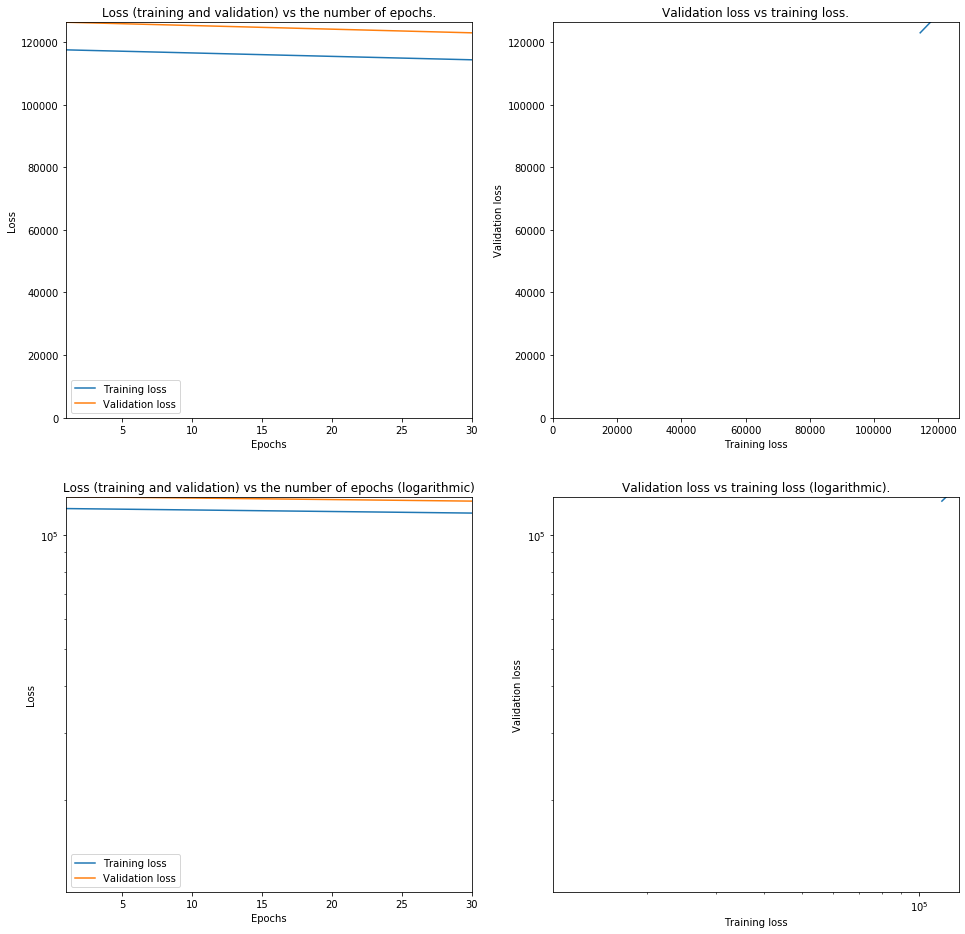

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 128)               1024      
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 128       
Total params: 1,152
Trainable params: 1,152
Non-trainable params: 0
_________________________________________________________________
Layer 0:  [array([[-0.09020173,  0.12061298, -0.15367521, ..., -0.02737004,
        -0.16576841, -0.20521998],
       [-0.06198069,  0.03651678,  0.0527227 , ...,  0.15288927,
        -0.03051089, -0.12901895],
       [-0.07956905,  0.07454852, -0.03948636, ...,  0.00734849,
        -0.08479637, -0.13747586],
       ...,
       [ 0.01435929,  0.17853758,  0.19083801, ..., -0.09933987,
         0.20143633, -0.11917718],
       [-0.00468052,  0.08538616,  0.06254947, ...,  0.0364071 ,
        -0.17707908,  0.0

In [379]:
fitDetails = model.fit(X, y, epochs=30, validation_split=0.3, verbose=1)
#fitDetails = model.fit(trainingInput['input'], trainingInput['target'], validation_split=0.3, epochs=30, verbose=1)
#fitDetails = model.fit(trainingInput['input'], trainingInput['target'], validation_split=0.3, epochs=30, verbose=1)

history = plotHistory(fitDetails)

evaluation = model.evaluate(validationInput['input'], validationInput['target'], verbose=0)
models.append({'model':model, 'name':str(prefixName) + name, 'evaluation':evaluation, 'history':history})
prefixName = prefixName + 1

model.summary()
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

In [380]:
model.layers[0].set_weights([np.array([[1] for i in range(8)])])
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

model.evaluate(X, y)

ValueError: Layer weight shape (8, 128) not compatible with provided weight shape (8, 1)

# Finishing

In [ ]:

#print(evaluation)

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
plt.show()

"""
makePredictionPlot(model, validationData)

for i in validationPlots:
    plotAndPredict(model, validationData, i)
"""
#"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()


In [ ]:
for i in range(len(models)):
    model = models[i]['model']
    print(models[i]['name'])
    print(model.summary())
    print(models[i]['evaluation'])
    model.save(saveFolder + '/' + models[i]['name'] + str(models[i]['evaluation']) + '.h5')
    print('\n \n')

#model = models[1][0]
#model.save('model1.h5')
#model = load_model('model1.h5')

# TEMP

In [ ]:
print(np.shape(trainingInput['input']))
print(np.shape(trainingInput['target']))

In [ ]:
dataset = np.loadtxt('pima-indians-diabetes.csv', delimiter=',')
#print(dataset)
# split into input (X) and output (y) variables
X = dataset[:,0:8]
y = dataset[:,8]

print(np.shape(X))
print(np.shape(y))
print(X)
print(y)

model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X, y, epochs=150, batch_size=10)